# Importing

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
pip install transformers seaborn nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
df_reviews = pd.read_csv('imdb_reviews.csv')
df_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
def map_sentiments(sentiment):
    if sentiment == 'positive':
        return 1
    return 0

df_reviews['sentiment'] = df_reviews['sentiment'].apply(map_sentiments)
df_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


def lowercase_text(text):
    return text.lower()

def remove_html(text):
    return re.sub(r'<[^<]+?>', '', text)

def remove_url(text):
    return re.sub(r'http[s]?://\S+|www\.\S+', '', text)

def remove_punctuations(text):
    tokens_list = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for char in text:
        if char in tokens_list:
            text = text.replace(char, ' ')

    return text

def remove_emojis(text):
    emojis = re.compile("["
                        u"\U0001F600-\U0001F64F"
                        u"\U0001F300-\U0001F5FF"
                        u"\U0001F680-\U0001F6FF"
                        u"\U0001F1E0-\U0001F1FF"
                        u"\U00002500-\U00002BEF"
                        u"\U00002702-\U000027B0"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U00010000-\U0010ffff"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u200d"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"
                        u"\u3030"
                        "]+", re.UNICODE)

    text = re.sub(emojis, '', text)
    return text

def remove_stop_words(text):
    stop_words = stopwords.words('english')
    new_text = ''
    for word in text.split():
        if word not in stop_words:
            new_text += ''.join(f'{word} ')

    return new_text.strip()

def stem_words(text):
    stemmer = PorterStemmer()
    new_text = ''
    for word in text.split():
        new_text += ''.join(f'{stemmer.stem(word)} ')

    return new_text

def preprocess_text(text):
    text = lowercase_text(text)
    text = remove_html(text)
    text = remove_url(text)
    text = remove_punctuations(text)
    text = remove_emojis(text)
    text = remove_stop_words(text)
    text = stem_words(text)

    return text

nltk.download('stopwords')
df_reviews['review'] = df_reviews['review'].apply(preprocess_text)
df_reviews.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,sentiment
0,one review mention watch 1 oz episod hook righ...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1


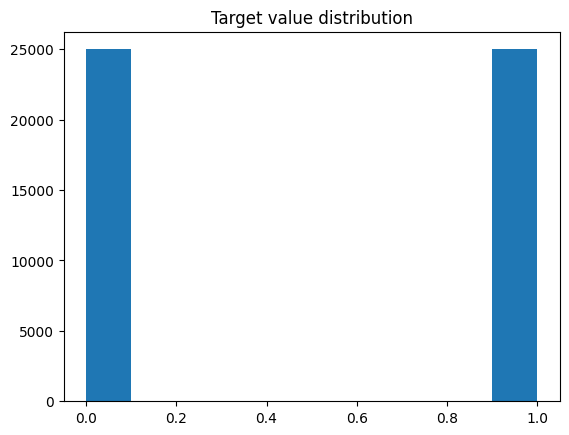

In [6]:
plt.title('Target value distribution')
plt.hist(df_reviews['sentiment'])
plt.show()

# Dataset and Dataloader

In [7]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install accelerate -U

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.


In [10]:
from transformers import AutoTokenizer
pre_trained_base = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pre_trained_base)

c:\Users\andre\1JUPYTER\dt_labs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
pip install transformers[torch]

In [12]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(pre_trained_base, num_labels = 2, output_attentions=False, output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
token_lens = []

for sentence in df_reviews['review']:
    tokens = tokenizer.encode(sentence, max_length=200, truncation=True)
    token_lens.append(len(tokens))

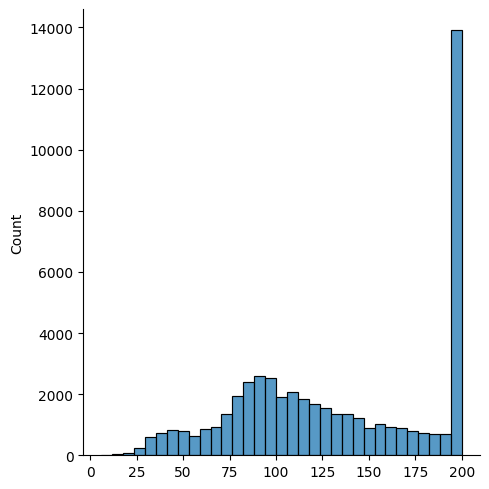

In [14]:
import seaborn as sns
sns.displot(token_lens);

In [15]:
SEED=42
MAX_LEN = 200
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_reviews, test_size=0.2, random_state=SEED)

In [16]:
def process_data(row):

    text = row['review']
    text = str(text)
    text = ' '.join(text.split())

    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LEN)

    encodings['label'] = row['sentiment']
    encodings['text'] = text

    return encodings

In [17]:
processed_data_tr = []

for i in range(df_train.shape[0]):
    processed_data_tr.append(process_data(df_train.iloc[i]))

In [18]:
processed_data_val = []

for i in range(df_val.shape[0]):
    processed_data_val.append(process_data(df_val.iloc[i]))

In [19]:
df_train = pd.DataFrame(processed_data_tr)
df_val = pd.DataFrame(processed_data_val)

In [20]:
df_train.head()

,attention_mask,input_ids,label,text,token_type_ids
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2921, 3198, 23624, 2954, 6978, 2674, 841...",0,kept ask mani fight scream match swear gener m...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 3422, 4372, 3775, 2099, 9587, 5737, 2071...",0,watch entir movi could watch entir movi stop d...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 3543, 2293, 2358, 10050, 2128, 25300, 11...",1,touch love stori reminisc in mood love draw h...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 3732, 2154, 11865, 15472, 2072, 8040, 73...",0,latter day fulci schlocker total abysm concoct...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2034, 3813, 3669, 19337, 2666, 2615, 504...",0,first firmli believ norwegian movi continu get...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Model

In [21]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [22]:
model.to(device);

In [23]:
pip install datasets evaluate

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pyarrow as pa
from datasets import Dataset

train_hg = Dataset(pa.Table.from_pandas(df_train))
valid_hg = Dataset(pa.Table.from_pandas(df_val))

In [25]:
import evaluate
import numpy as np

# Load both accuracy and f1 metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Metric helper method
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    # Compute F1 score
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    # Combine the metrics into a single dictionary
    combined_metrics = {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1']
    }

    return combined_metrics

In [26]:
pip show accelerate transformers

Name: accelerateNote: you may need to restart the kernel to use updated packages.

Version: 0.31.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: c:\Users\andre\1JUPYTER\dt_labs\.venv\Lib\site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 
---
Name: transformers
Version: 4.41.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: c:\Users\andre\1JUPYTER\dt_labs\.venv\Lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [27]:
from transformers import TrainingArguments, Trainer

EPOCHS = 1

training_args = TrainingArguments(output_dir="./result",
                                  evaluation_strategy="epoch",
                                  num_train_epochs= EPOCHS,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=8
                                )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hg,
    eval_dataset=valid_hg,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

c:\Users\andre\1JUPYTER\dt_labs\.venv\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
print("CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)

CUDA available:  True
CUDA version:  12.1


In [29]:
trainer.train()

  0%|          | 0/2500 [00:00<?, ?it/s]c:\Users\andre\1JUPYTER\dt_labs\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
 20%|██        | 500/2500 [05:35<22:22,  1.49it/s]

{'loss': 0.4994, 'grad_norm': 12.613661766052246, 'learning_rate': 4e-05, 'epoch': 0.2}


 40%|████      | 1000/2500 [11:13<16:46,  1.49it/s]

{'loss': 0.3898, 'grad_norm': 4.661791801452637, 'learning_rate': 3e-05, 'epoch': 0.4}


 60%|██████    | 1500/2500 [16:47<11:02,  1.51it/s]

{'loss': 0.3516, 'grad_norm': 1.5203113555908203, 'learning_rate': 2e-05, 'epoch': 0.6}


 80%|████████  | 2000/2500 [22:25<05:33,  1.50it/s]

{'loss': 0.3121, 'grad_norm': 8.331348419189453, 'learning_rate': 1e-05, 'epoch': 0.8}


100%|██████████| 2500/2500 [28:04<00:00,  1.50it/s]

{'loss': 0.2882, 'grad_norm': 6.287994861602783, 'learning_rate': 0.0, 'epoch': 1.0}


                                                   
100%|██████████| 2500/2500 [30:45<00:00,  1.35it/s]

{'eval_loss': 0.283893883228302, 'eval_accuracy': 0.883, 'eval_f1': 0.8829425082505502, 'eval_runtime': 159.717, 'eval_samples_per_second': 62.611, 'eval_steps_per_second': 7.826, 'epoch': 1.0}
{'train_runtime': 1845.2907, 'train_samples_per_second': 21.677, 'train_steps_per_second': 1.355, 'train_loss': 0.3682089477539062, 'epoch': 1.0}


TrainOutput(global_step=2500, training_loss=0.3682089477539062, metrics={'train_runtime': 1845.2907, 'train_samples_per_second': 21.677, 'train_steps_per_second': 1.355, 'total_flos': 4111110240000000.0, 'train_loss': 0.3682089477539062, 'epoch': 1.0})

In [38]:
torch.save(model.state_dict(), 'model.pth')

In [39]:
model.save_pretrained('./model/')

In [40]:
trainer.save_model("./model/")

In [33]:
import shutil

# Create a zip file
shutil.make_archive('imdb_model', 'zip', './model')

'c:\\Users\\andre\\1JUPYTER\\dt_labs\\imdb_model.zip'

# Teste de predições individuais

In [34]:
from transformers import AutoTokenizer

new_tokenizer = AutoTokenizer.from_pretrained(pre_trained_base)

In [35]:
def get_prediction(text):
    encoding = new_tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=MAX_LEN)
    encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

    outputs = model(**encoding)

    logits = outputs.logits

    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().cpu())
    probs = probs.detach().numpy()
    label = np.argmax(probs, axis=-1)

    return label

In [36]:
get_prediction("This movie is horrible!")

0

In [37]:
get_prediction("This movie is awesome!")

1